In [1]:
from bs4 import BeautifulSoup
import json
import pandas as pd
import numpy as np

import spacy
from spacy.tokenizer import Tokenizer
from spacy.lang.char_classes import ALPHA, ALPHA_LOWER, ALPHA_UPPER, CONCAT_QUOTES, LIST_ELLIPSES, LIST_ICONS
from spacy.util import compile_infix_regex
from spacy.lang.en import English
from spacy.lang.en.stop_words import STOP_WORDS

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split

import unicodedata
import re
import string
import contractions

# Assumptions

1. metadata not important as it is in and of itself a keyword
    - often common across multiple listing
    - goal of tagging is to find unique elements and differences between listings
    - eg. what's the point in tagging all ads with 'Melbourne'


2. This model is for English words only


3. Numbers don't matter in terms of skills
    - words are enough
    - eg. extracting the skill 'python' is sufficient without having something like '3 years python'


4. lowercase tagging is ok
    - if the word were 'OHS' for Occupation Health and Safety, then the tag would be 'ohs'
    - can be capitalised as part of a future improvement


5. hyphenated words treated as single words


6. 'standout' metadata is not important for skills as it predominantly speaks about job perks, 
    not about candidate requirements.
    - Rationale: If a requirements is in the 'standout' section and it is truly important, it will also be mentioned in the content of the job ad
    - -> 'standout' is excluded
    

7. 'additionalSalaryText' not useful in determining what would make a successful candidate.
    Largely speaks about perks instead of skills
    - -> 'additionalSalaryText' is excluded
    

8. 'classification' and 'subClassification' are slightly more generic than 'title'
    - therefore, the are more likely to be useful when grouping documents, or determining the amount of clusters


9. Replacing special characters with a similar English letter will not (or only rarely) alter a word's meaning 
    - eg. changing 'é' -> 'e', will cause 'café' -> 'cafe', but 'cafe' is not a different English word with a different meaning
    
    
10. 'abstract' too short to be of real use. 
    - Too much off a focus, generally speaking on perks and not on skills.
    - -> abstract is excluded

# Limitations

### Data

    (Points 1, 2 and 3 are not necessarily a big problem for skill extraction, but if this were my job, 
    I would raise this as if the dataset was used for other applications, then it may need to be addressed)
    
    
1. Not all metadata keys not consistently present, making it harder to make use of that information
    eg. 'suburb' or 'area' for targeted job advertisements within a city
    

2. 'area' metadata sometimes populated with city name
    eg. Sydney, Perth


3. 'area', 'location' and suburb' appear to have overlapping datasets
    - Having more descriptive key names may help data quality if this is user input
    eg. 'city' or 'areaCode'
    
    
4. Spelling errors show up as a separate words, 
    - and therefore separate ngrams
    - lemmatisation may not work properly, etc.


5. My model is not fit for production as extremely large datasets, will give many candidate ngrams, leading to a high-dimensional, sparsely-populated matrix, that will require a lot of memory
    - Next step to explore different featurisation methods that populate document vectors more densely (eg. GloVe, Word2Vec, BERT)

# Methods

### Candidate word extraction
* Bag of Words
* Bag of N-grams

### Featurising 
* Naiive counting
    - Focus only on frequency, bad for generic words that are not stop words
* TF-IDF
    + a lot of documents
    + fast
    + eg. the word candidate, probably appears in most ads (and multiple times), but is not a stopword

* GloVe
* Word2Vec
* BERT

### ML
* Unsupervised
    - K-Means Clustering   




# Load and parse data

In [3]:
# Read data and parse into DataFrame
data = []

# rename data file
with open('data.json', 'r', encoding='utf-8') as f:
    ads = f.readlines()

for ad in ads:
    ad = json.loads(ad)
    md = ad['metadata']
    
    assert 'classification' in md.keys()
    assert 'subClassification' in md.keys()
    assert 'location' in md.keys()
    assert 'workType' in md.keys()

for ad in ads:
    ad = json.loads(ad)
    md = ad['metadata']
    

    classification = md['classification']['name']
    sub_classification = md['subClassification']['name']
    loc = md['location']['name']
    work_type = md['workType']['name']
    try:
        area = md['area']['name']
    except KeyError:
        area = None
    try:
        suburb = md['suburb']['name']
    except KeyError:
        suburb = None
        
    # extract metadata columns to top level in dict
    ad.update({\
               'classification': classification, \
               'subClassification': sub_classification, \
               'area': area, \
               'location': loc, \
               'suburb': suburb, \
               'workType': work_type\
              })
    
    # don't need the rest of metadata - see Assumptions
    ad.pop('metadata')
    data.append(ad)

corpus = pd.DataFrame(data, columns=data[0].keys())
corpus.drop_duplicates(inplace=True)
N = 5000
corpus = corpus[:N]
corpus = corpus.set_index('id')
corpus.head(3)

,title,abstract,content,classification,subClassification,area,location,suburb,workType
id,,,,,,,,,
38915469,Recruitment Consultant,We are looking for someone to focus purely on ...,<HTML><p>Are you looking to join a thriving bu...,Education & Training,Other,None,Sydney,None,Full Time
38934839,Computers Salesperson - Coburg,Passionate about exceptional customer service?...,<HTML><p>&middot;&nbsp;&nbsp;Casual hours as r...,Retail & Consumer Products,Retail Assistants,Northern Suburbs,Melbourne,Coburg,Casual/Vacation
38946054,Senior Developer | SA,Readifarians are known for discovering the lat...,<HTML><p>Readify helps organizations innovate ...,Information & Communication Technology,Consultants,None,Adelaide,None,Full Time


# Exploratory analysis

In [4]:
# Get a feel for the shape of data to help intuition with number keywords per ad, etc.
print(corpus.abstract.apply(lambda x: x.split(' ')).apply(len).describe())  # not used - see Assumptions
print()
print(corpus.content.apply(lambda x: x.split(' ')).apply(len).describe())


count    5000.000000
mean       18.010000
std         5.245475
min         1.000000
25%        15.000000
50%        19.000000
75%        22.000000
max        32.000000
Name: abstract, dtype: float64

count    5000.000000
mean      307.618400
std       156.327706
min        10.000000
25%       203.000000
50%       284.000000
75%       382.000000
max      2050.000000
Name: content, dtype: float64


### Helper functions

In [90]:
def remove_html_tags(doc):
    return BeautifulSoup(doc, 'html.parser').get_text(separator=' ', strip=True).replace('\xa0', ' ')


def expand_contractions(doc):
    return contractions.fix(doc)


def to_lower(doc):
        return doc.lower()

    
def remove_duplicate_spaces(doc):
    return re.sub('s+',' ', doc)


def remove_numbers(doc):
    return re.sub('\d+', '', doc)


def remove_special_chars(doc):
    '''
    removes all characters except for common punctuation, A-Z (upper and lowercase) and 0-9
        common punctuation:  -!?.,()
    '''
    return re.sub('[^a-zA-Z0-9-.,?!()\/\s]+', '', doc)


def remove_punctuation(tokens):
    punctuation = list(string.punctuation)
    return [t for t in tokens if t not in punctuation]


def remove_stop_words(tokens, stop_words):
    return [t for t in tokens if not t.is_stop]    
    
    
def replace_accented_chars(doc):
    return unicodedata.normalize('NFKD', doc).encode('ascii', 'ignore').decode('utf-8', 'ignore')

text = 'testing the characters: café, ä, ü, ï, ö, ë, ÿ'
assert replace_accented_chars(text) == 'testing the characters: cafe, a, u, i, o, e, y'


def remove_emails(doc):
    return re.sub(r'\S*@\S*\s?', '', doc).strip()

text = 'chardrew@outlook.com.au ... For more information please email me on paul@traveltraderecruitment.com.au or (02) 9119 '
assert remove_emails(text) == '... For more information please email me on or (02) 9119'


def remove_URLs(doc):
    return re.sub(r'http\S+', '', doc).strip()


def remove_words_with_numbers(doc):
    return re.sub(r'\w*\d\w*', '', doc).strip()


def custom_tokenizer(nlp):
    '''
    Custom spaCy tokeniser that behaves same as default, but does not split on intra-word hyphens
    eg. 'well-organised' will be one token, instead of 3.
    '''
    infixes = (
        LIST_ELLIPSES
        + LIST_ICONS
        + [
            r"(?<=[0-9])[+\-\*^](?=[0-9-])",
            r"(?<=[{al}{q}])\.(?=[{au}{q}])".format(
                al=ALPHA_LOWER, au=ALPHA_UPPER, q=CONCAT_QUOTES
            ),
            r"(?<=[{a}]),(?=[{a}])".format(a=ALPHA),
            # when not commented out, the line below splits tokens on intraword hyphens
            #r"(?<=[{a}])(?:{h})(?=[{a}])".format(a=ALPHA, h=HYPHENS),  
            r"(?<=[{a}0-9])[:<>=/](?=[{a}])".format(a=ALPHA),
        ]
    )

    infix_re = compile_infix_regex(infixes)

    return Tokenizer(nlp.vocab, prefix_search=nlp.tokenizer.prefix_search,
                                suffix_search=nlp.tokenizer.suffix_search,
                                infix_finditer=infix_re.finditer,
                                token_match=nlp.tokenizer.token_match,
                                rules=nlp.Defaults.tokenizer_exceptions)


def word_tokenise(doc):
    tokens = nlp(doc)
    return tokens


def join_tokens(tokens):
    doc = ' '.join(tokens)
    return doc

    
def lemmatise(tokens):
    '''
    returns lemmatised tokens as a list not as a spaCy object
    '''
    return [t.lemma_ for t in tokens]


def keep_pos_tags(tokens, tags):
    '''
    removes tokens that are not of type <tag>.
    Refer to: https://spacy.io/usage/linguistic-features
    '''
    for tag in tags:
        assert tag in ['PROPN', 'AUX', 'VERB', 'ADP', 'NOUN', 'SYM', 'NUM', 'DET']
        
    return [t for t in tokens if t.pos_ in tags]

    
def clean_doc(doc):
    n = doc
    n = remove_html_tags(n)
    n = expand_contractions(n)
    n = replace_accented_chars(n)
    n = remove_URLs(n)
    n = remove_emails(n)
    n = remove_numbers(n)
    n = remove_special_chars(n)
    
    return n
    
    
def normalise_doc(doc):
    n = doc
    n = remove_words_with_numbers(n)
    t = word_tokenise(n)
    t = keep_pos_tags(t, ['NOUN', 'VERB'])
    t = remove_stop_words(t, stop_words)
    t = lemmatise(t)
    n = join_tokens(t)
    
    return n


def get_stop_words():
    stop_words = STOP_WORDS
    return stop_words


# Clean data

In [18]:
nlp = spacy.load("en_core_web_sm")
my_tokenizer = custom_tokenizer(nlp)
nlp.tokenizer = my_tokenizer
stop_words = get_stop_words()

corpus['content_cleaned'] = corpus.content.apply(lambda x: clean_doc(x))
corpus.head()

,title,abstract,content,classification,subClassification,area,location,suburb,workType,content_cleaned,content_normalised
id,,,,,,,,,,,
38915469,Recruitment Consultant,We are looking for someone to focus purely on ...,<HTML><p>Are you looking to join a thriving bu...,Education & Training,Other,None,Sydney,None,Full Time,Are you looking to join a thriving business th...,look join business reward work difference life...
38934839,Computers Salesperson - Coburg,Passionate about exceptional customer service?...,<HTML><p>&middot;&nbsp;&nbsp;Casual hours as r...,Retail & Consumer Products,Retail Assistants,Northern Suburbs,Melbourne,Coburg,Casual/Vacation,Casual hours as required (transition to Part-t...,hour require transition commission base struct...
38946054,Senior Developer | SA,Readifarians are known for discovering the lat...,<HTML><p>Readify helps organizations innovate ...,Information & Communication Technology,Consultants,None,Adelaide,None,Full Time,Readify helps organizations innovate with tech...,readify help organization innovate technology ...
38833950,Senior Commercial Property Manager | Leading T...,~ Rare opportunity for a Senior PM to step int...,<HTML><p><strong>WayPoint Recruitment&nbsp;</s...,Real Estate & Property,"Commercial Sales, Leasing & Property Mgmt",CBD & Inner Suburbs,Melbourne,Melbourne,Full Time,WayPoint Recruitment have partnered up with a ...,partner agency growth month opportunity join e...
38856271,Technology Manager | Travel Industry,Rare opportunity for an experienced Technology...,<HTML>This is a key role within a market leadi...,Information & Communication Technology,Management,None,Auckland,None,Full Time,This is a key role within a market leading Tra...,role market lead company share market look str...


# Select candidate ngrams and clean some more

In [94]:
def get_candidates(series): 
    pattern = '(?u)\\b[\\w-]+\\b'  # keep intra-word hyphens
    cv = CountVectorizer(ngram_range=(1, 3), token_pattern=pattern)
    ngrams = cv.fit_transform(series.apply(lambda x: x.lower()))
    #ngrams = cv.fit_transform(corpus.content_cleaned.apply(lambda x: x.lower()))
    candidates = cv.get_feature_names()
    return cv, candidates

_, candidates_all = get_candidates(corpus.content_cleaned)
print(len(candidates_all))

1279581


In [95]:
corpus['content_normalised'] = corpus.content_cleaned.apply(lambda x: normalise_doc(x))
_, candidates_normalised = get_candidates(corpus.content_normalised)
print(len(candidates_normalised))

687681


In [102]:
# Get intersection between two candidate sets
candidates = list(set(candidates_normalised).intersection(candidates_all))
print(len(candidates))
candidates

60378


['handoff',
 'sleep monitoring set',
 'swallowing experience',
 'safety environment compliance',
 'licence feel',
 'team finance',
 'service health',
 'experience istqb certification',
 'tool integration',
 'client quote request',
 'expert join',
 'review advice',
 'standard manage project',
 'midnight',
 'www adarapartners org',
 'service portfolio',
 'hand operation',
 'supply planning',
 'online system',
 'vms',
 'study assistance reward',
 'form problem',
 'love adventure',
 'provide bookkeeping payroll',
 'undertake maintenance',
 'man',
 'diary management experience',
 'telecommunications food manufacturing',
 'churn',
 'march',
 'litigation dispute',
 'compliance provide advice',
 'environment click',
 'site ensuring adherence',
 'feasibility grid',
 'kitchen operation',
 'deliver telehealth',
 'employee agreement register',
 'qualification ability',
 'generate value',
 'axle truck',
 'look like',
 'career fun',
 'support expand',
 'portfolio approach',
 'proof-of-concept',
 'de

In [103]:
# hack way to reduce noise: remove ngrams that contain a stopword
candidates_bad = [x for x in candidates if len(set(x.split(' ')).intersection(stop_words)) > 0]
candidates = [x for x in candidates if x not in candidates_bad]


### Statistically best candidate keywords...

#### ... for a specific document, when TF-IDF is run across the entire corpus

In [104]:
# create vectorizer and assign pre-determined vocab
tfIdfVectorizer = TfidfVectorizer(use_idf=True)
tfIdfVectorizer.vocabulary = candidates

# fit vectorizer and transform content_cleaned into features
X = tfIdfVectorizer.fit_transform(corpus.content_cleaned)  

assert tfIdfVectorizer.vocabulary == list(tfIdfVectorizer.get_feature_names())
assert tfIdfVectorizer.vocabulary == candidates


df = pd.DataFrame(X[2].T.todense(), index=candidates, columns=["TF-IDF"])
df = df.sort_values('TF-IDF', ascending=False)
print (df.head(10))

               TF-IDF
software     0.446904
readify      0.422135
expect       0.175533
scheme       0.166830
development  0.162820
shipping     0.157219
react        0.142606
etc          0.133190
interstate   0.132681
server       0.123747


#### ... for a specific document, when TF-IDF is run across the classification to which the document belongs

In [105]:
tfIdfVectorizer_IT=TfidfVectorizer(use_idf=True, ngram_range=(1,3))
tfIdfVectorizer_IT.vocabulary = candidates
X_IT = tfIdfVectorizer_IT.fit_transform(corpus[corpus.classification == 'Information & Communication Technology'].content_cleaned)

df_IT = pd.DataFrame(X_IT[0].T.todense(), index=candidates, columns=["TF-IDF"])
df_IT = df_IT.sort_values('TF-IDF', ascending=False)
print (df_IT.head(10))

                            TF-IDF
readify                   0.339390
software                  0.294485
expect                    0.205793
scheme                    0.191914
shipping                  0.159176
allowance                 0.145924
interstate                0.145924
development               0.144596
software development      0.130874
professional development  0.119214


Notice how more unique words have risen towards the top (eg. readify, company name). 

# Learning algorithm (Clustering)

In [106]:
X_train, X_test = train_test_split(X, test_size=0.2, random_state=1)
max_clusters = round(1.5*len(corpus.classification.unique()))
# for k in range(1, max_clusters):
n_clusters = 10 # optimal n_clusters determined using elbow method 

kmeans = KMeans(n_clusters=n_clusters)
kmeans.fit(X_train);
#kmeans.inertia_ for plotting elbow method to get k_opt

In [107]:
pred = kmeans.predict(X_test)  # TODO see if having X_test is even worth it
cluster_labels = list(kmeans.labels_) + (list(pred))
corpus['centroid'] = cluster_labels

In [108]:
def get_top_N_elements(elements, scores, N):
    scores = np.array(scores)
    i = np.argsort(scores)[-N:]  # extract indices for largest N values in e
    i = np.flip(i)
    return {elements[j]: scores[j] for j in i} # extract corresponding values and sort largest -> smallest


tfIdf_vec_cluster=TfidfVectorizer(use_idf=True, ngram_range=(1,3))
tfIdf_vec_cluster.vocabulary = candidates

corpus['keywords'] = pd.Series(dtype=object) # preallocate
N_doc = 5  # number of keywords to extract from each document

for cluster in range(n_clusters):
    # extract documents for current cluster
    sub_corpus = corpus[corpus.centroid == cluster]
    
    # run TF-IDF over cluster
    X_cluster = tfIdf_vec_cluster.fit_transform(sub_corpus.content_normalised)  
    
    # fetch top keywords from TF-IDF results
    doc_keywords = pd.DataFrame(X_cluster.T.todense(), columns=sub_corpus.index, index=candidates)
    doc_keywords = doc_keywords.apply(lambda x: get_top_N_elements(elements=candidates, scores=x, N=N_doc)).rename('keywords')
    
    # update keywords column for cluster
    corpus.loc[corpus.centroid==cluster, 'keywords'] = doc_keywords.values

    
# get cluster centroid vectors   
clusters = pd.DataFrame(kmeans.cluster_centers_, columns=candidates)
cluster_keywords = [None] * n_clusters

# get keywords for each cluster centroid vector
for index, row in clusters.iterrows():
    N_cluster = 15  # num keywords to extract for centroid
    cluster_keywords[index] = get_top_N_elements(elements=candidates, scores=row, N=N_cluster)

# Keywords for a specific document

- from_doc: ad-specific keywords based on content
- from_cluster: generic keywords based on the ad's cluster

In [110]:
from pprint import pprint as pp

# for example, for a single document
doc_id = 38856271
doc_id = str(doc_id)
doc = corpus.loc[doc_id]
cluster = doc.centroid
cluster_keywords[cluster]
kws_doc = doc.keywords  # keywords obtained directly from document
kws_clust = cluster_keywords[cluster]  # keywords commonly used by this document's cluster
kws = {'from_doc': kws_doc,
       'from_cluster': kws_clust}

pp(kws)

{'from_cluster': {'ability': 0.027047671712373284,
                  'business': 0.05212502956596971,
                  'development': 0.032870016183515566,
                  'experience': 0.040972765814446026,
                  'management': 0.04168874684863698,
                  'marketing': 0.039355341360813506,
                  'opportunity': 0.026836453297608778,
                  'people': 0.03422755829691835,
                  'role': 0.04416979777734053,
                  'skills': 0.03371927515537205,
                  'strong': 0.026882161315551996,
                  'support': 0.029265364896234308,
                  'team': 0.04135666285921888,
                  'work': 0.03914486596683464,
                  'working': 0.028861169775736027},
 'from_doc': {'business': 0.19877273260070905,
              'lead': 0.15809021597420606,
              'platform provide': 0.2109613367676491,
              'support business': 0.15511733278565545,
              'team business': 0.1777

# Dimensionality reduction to visualise in 2D

No handles with labels found to put in legend.


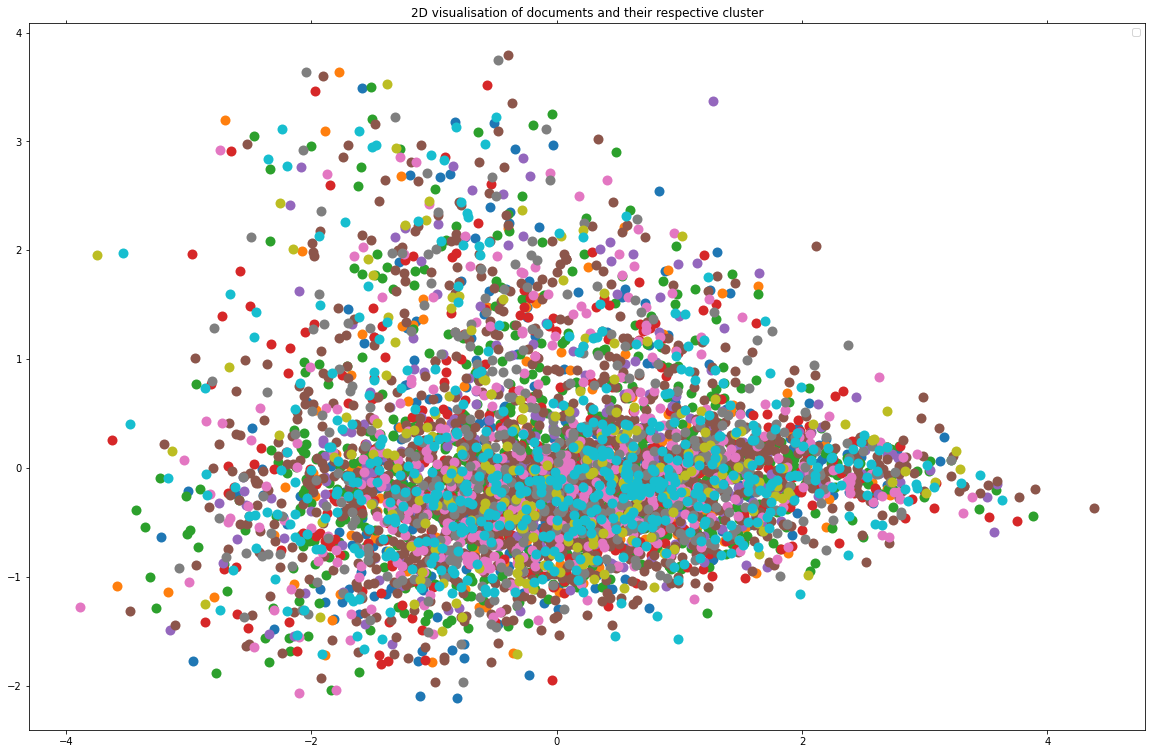

In [111]:
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

dist = 1 - cosine_similarity(X)
pca = PCA(2)
pca.fit(dist)
X_PCA = pca.transform(dist)

labels = corpus.centroid
x, y = X_PCA[:, 0], X_PCA[:, 1]


df = pd.DataFrame({'x': x, 'y':y, 'label':labels}) 
groups = df.groupby('label')

fig, ax = plt.subplots(figsize=(20, 13)) 

for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=n_clusters, mec='none')
    ax.set_aspect('auto')
    ax.tick_params(axis='x',which='both',bottom='off',top='off',labelbottom='off')
    ax.tick_params(axis= 'y',which='both',left='off',top='off',labelleft='off')
    
ax.legend()
ax.set_title("2D visualisation of documents and their respective cluster")
plt.show()

Visualisation for fun, clusters are not well-separated in 2D, but space is ~60k dimensional.

# Clusters are unique and have distinct themes

In [113]:
cluster_keywords[0]  # healthcare

{'care': 0.20088779718774563,
 'health': 0.12199282476774068,
 'services': 0.06116466234222608,
 'community': 0.05948399586090366,
 'support': 0.052807489796362385,
 'hospital': 0.049610648015924026,
 'nurse': 0.04858778576952982,
 'people': 0.04769654037164696,
 'work': 0.04435085629718044,
 'team': 0.04298791162668878,
 'registered': 0.042622017431551744,
 'nursing': 0.03969748607287315,
 'current': 0.03902580648648765,
 'staff': 0.03690476771239862,
 'service': 0.03643022388835527}

In [114]:
cluster_keywords[1]  # education

{'school': 0.1355789921811419,
 'children': 0.1321862228614693,
 'education': 0.10503235302737932,
 'learning': 0.10452589052286618,
 'teaching': 0.09886774454720125,
 'childhood': 0.07453958142350027,
 'child': 0.07033805264172106,
 'teacher': 0.05929833140695555,
 'centre': 0.054336291281228494,
 'care': 0.049830207200358294,
 'student': 0.04275525174701456,
 'community': 0.042196133859640564,
 'quality': 0.041452028771233926,
 'position': 0.03995482783424333,
 'college': 0.03898704543757145}

In [116]:
cluster_keywords[2]  # construction, licensed operator

{'work': 0.05852655457315041,
 'maintenance': 0.05054161797226738,
 'experience': 0.04760467293774364,
 'equipment': 0.03994063561770633,
 'licence': 0.03588219671996694,
 'role': 0.032789901506684725,
 'team': 0.03256948821828122,
 'company': 0.03056440476218574,
 'construction': 0.03028249539880753,
 'safety': 0.02959406362539078,
 'apply': 0.029415105991285724,
 'mining': 0.029357668342097496,
 'trade': 0.02927782514431929,
 'required': 0.028048244785704005,
 'skills': 0.02749755736756162}

In [117]:
cluster_keywords[3]  # big data/data engineering

{'experience': 0.07450113575784299,
 'data': 0.0712218187723316,
 'design': 0.0706605071962272,
 'technical': 0.05387233765263289,
 'business': 0.05210000585467873,
 'development': 0.046624606201321514,
 'security': 0.045663096070742135,
 'software': 0.04314412769865393,
 'systems': 0.03873761112041551,
 'role': 0.03843422641069307,
 'technology': 0.03719335555218042,
 'skills': 0.03665199127298713,
 'team': 0.03654038420240048,
 'working': 0.036141310505492054,
 'developer': 0.03587313445684249}

In [120]:
cluster_keywords[4]  # construction

{'project': 0.19273388736892255,
 'projects': 0.14190232275920914,
 'construction': 0.09142408314258924,
 'experience': 0.05895193838961056,
 'site': 0.05664548512286769,
 'management': 0.056351819741211444,
 'design': 0.054037225921939255,
 'engineering': 0.052829855487668824,
 'civil': 0.04931402450882227,
 'commercial': 0.04925417322842104,
 'role': 0.049184480281758404,
 'work': 0.048693774108817416,
 'team': 0.04598464893751019,
 'manager': 0.04285773333382091,
 'company': 0.040176329454501836}

In [121]:
cluster_keywords[5]  # marketing and management

{'business': 0.05212502956596971,
 'role': 0.04416979777734053,
 'management': 0.04168874684863698,
 'team': 0.04135666285921888,
 'experience': 0.040972765814446026,
 'marketing': 0.039355341360813506,
 'work': 0.03914486596683464,
 'people': 0.03422755829691835,
 'skills': 0.03371927515537205,
 'development': 0.032870016183515566,
 'support': 0.029265364896234308,
 'working': 0.028861169775736027,
 'ability': 0.027047671712373284,
 'strong': 0.026882161315551996,
 'opportunity': 0.026836453297608778}

In [122]:
cluster_keywords[6]   # cooking/restaurant industry

{'work': 0.06348370116899314,
 'hours': 0.051093732981956,
 'food': 0.046662517166645635,
 'available': 0.04481938891889146,
 'forklift': 0.04337176684893029,
 'experience': 0.043180678511988875,
 'team': 0.038005764227147416,
 'week': 0.03765661396220714,
 'role': 0.0366203548905369,
 'cafe': 0.03421392077355775,
 'warehouse': 0.033549985098171045,
 'time': 0.03284612204545887,
 'cook': 0.0309301396219754,
 'casual': 0.02994104386827277,
 'reliable': 0.029743468599402828}

In [123]:
cluster_keywords[7]  # Executive assitant

{'office': 0.0654908856550822,
 'skills': 0.0634791240576813,
 'role': 0.05871730126611128,
 'administration': 0.057710891532813176,
 'experience': 0.05360374103358944,
 'team': 0.052509885713116,
 'support': 0.04610853093337747,
 'payroll': 0.04600981413210886,
 'property': 0.04280136769276592,
 'work': 0.04199060285972699,
 'duties': 0.04197496269505347,
 'management': 0.03951060293080794,
 'excellent': 0.037718549601233824,
 'ability': 0.03715109973318599,
 'processing': 0.03372448527914615}

In [124]:
cluster_keywords[8]  # Accounting / auditor

{'financial': 0.1334412606045464,
 'accounting': 0.11573529572100628,
 'firm': 0.09300853574641069,
 'tax': 0.07703232840880696,
 'finance': 0.0742123200174667,
 'business': 0.07342461370374777,
 'accountant': 0.06989304297353278,
 'audit': 0.06736562504723041,
 'reporting': 0.0639986812128388,
 'role': 0.05569039231708183,
 'cpa': 0.050304045960227944,
 'experience': 0.04637523838565153,
 'team': 0.04606019893392619,
 'client': 0.043094394259451725,
 'preparation': 0.041886553194733354}

In [125]:
cluster_keywords[9]  # retail/customer service

{'customer': 0.1265257396054686,
 'service': 0.08773783923260935,
 'team': 0.06187942886577168,
 'store': 0.05878245160195096,
 'retail': 0.05566315526083974,
 'experience': 0.05264492324692557,
 'skills': 0.05108853071637772,
 'role': 0.04389186903455687,
 'work': 0.04364433428565915,
 'great': 0.04152460911376952,
 'business': 0.0360954113801421,
 'career': 0.034393985672812086,
 'ability': 0.03217411970481974,
 'company': 0.03193555295469473,
 'looking': 0.031867274271256414}